# <center> The effect of weather temperature on frequency of crimes </center>

In this notebook, I examine the relationship between weather temperature and frequency of crimes. This analysis is based on crimes data from **January,1st 2012** until **June, 7th 2017**. This dataset was pulled from City of Chicago Data Portal [link](https://data.cityofchicago.org/Public-Safety/Crimes-One-year-prior-to-present/x2n5-8w5q). I also collected historical weather data from **January,1st 2012** until **June, 7th 2017** [link](http://mrcc.isws.illinois.edu/CLIMATE/restricted.jsp?accessdenied=%2FCLIMATE%2Fwelcome.jsp).

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#Compiling multiple csv files present in a folder together in one dataframe.
data = pd.DataFrame()
for f in glob.glob('./crimeData/*.csv'):
    data = pd.concat([data,pd.read_csv(f)])

In [3]:
#Reading in Weather Data (average daily temperature)
temp = pd.read_csv('./climate_Data_Jan_1_2012_up_to_Jun_7_2017.csv')
temp.columns

Index(['Date', 'Mean_Temp'], dtype='object')

In [4]:
'''
cleanDate_W: cleans and re-formats the date column in the weather data
'''
def cleanDate_W(d):
    return (datetime.strptime(str(d), '%m/%d/%y').date())
temp['Date'] = temp['Date'].apply(cleanDate_W)
temp['Date']= pd.to_datetime(temp['Date'],errors='coerce')

temp['Day']= temp['Date'].dt.day
temp['Month']= temp['Date'].dt.month
temp['Year']= temp['Date'].dt.year

In [5]:
'''
cleanDate_S: cleans and re-formats the date column in the shootings data
'''
def cleanDate_S(d):
    if(d==''):
        return (d)
    else:
        return (datetime.strptime(str(d) ,'%m/%d/%Y %H:%M:%S %p').date()) #converting dates from type string to type date and time
data['Date'] = data['Date'].apply(cleanDate_S)
data['Date'] = pd.to_datetime(data['Date'],errors='coerce')

In [6]:
#merging the shootings and temp data based on the Date column
crimeTemp = data.merge(temp,how='inner',left_on='Date',right_on='Date')

In [7]:
crimeTemp.shape

(1557499, 26)

In [8]:
#checking if the new column (Mean_Temp) has been added
crimeTemp.columns

Index(['Arrest', 'Beat', 'Block', 'Case Number', 'Community Area', 'Date',
       'Description', 'District', 'Domestic', 'FBI Code', 'ID', 'IUCR',
       'Latitude', 'Location', 'Location Description', 'Longitude',
       'Primary Type', 'Updated On', 'Ward', 'X Coordinate', 'Y Coordinate',
       'Year_x', 'Mean_Temp', 'Day', 'Month', 'Year_y'],
      dtype='object')

In [9]:
crimeTemp.head(4)

,Arrest,Beat,Block,Case Number,Community Area,Date,Description,District,Domestic,FBI Code,...,Primary Type,Updated On,Ward,X Coordinate,Y Coordinate,Year_x,Mean_Temp,Day,Month,Year_y
0,False,523,120XX S STATE ST,JA305491,53.0,2012-06-22,FINANCIAL IDENTITY THEFT OVER $ 300,5.0,False,11,...,DECEPTIVE PRACTICE,06/14/2017 03:55:10 PM,9.0,NaN,NaN,2012,75.5,22,6,2012
1,False,632,007XX E 87TH ST,HV348021,44.0,2012-06-22,POCKET-PICKING,6.0,False,06,...,THEFT,02/04/2016 06:33:39 AM,6.0,1182609.0,1847455.0,2012,75.5,22,6,2012
2,False,713,012XX W 59TH ST,HV347871,67.0,2012-06-22,OVER $500,7.0,False,06,...,THEFT,02/04/2016 06:33:39 AM,16.0,1169247.0,1865660.0,2012,75.5,22,6,2012
3,False,421,026XX E 78TH ST,HW245911,43.0,2012-06-22,PAY TV SERVICE OFFENSES,4.0,False,11,...,DECEPTIVE PRACTICE,08/17/2015 03:03:40 PM,7.0,NaN,NaN,2012,75.5,22,6,2012


In [10]:
C_count = crimeTemp [['Date','Primary Type','Mean_Temp']]
C_count ['Year'] = C_count['Date'].dt.year
C_count ['Month'] = C_count['Date'].dt.month
C_count ['Day'] = C_count['Date'].dt.day

-----------------

# Trend of Temperature in the past 5 years

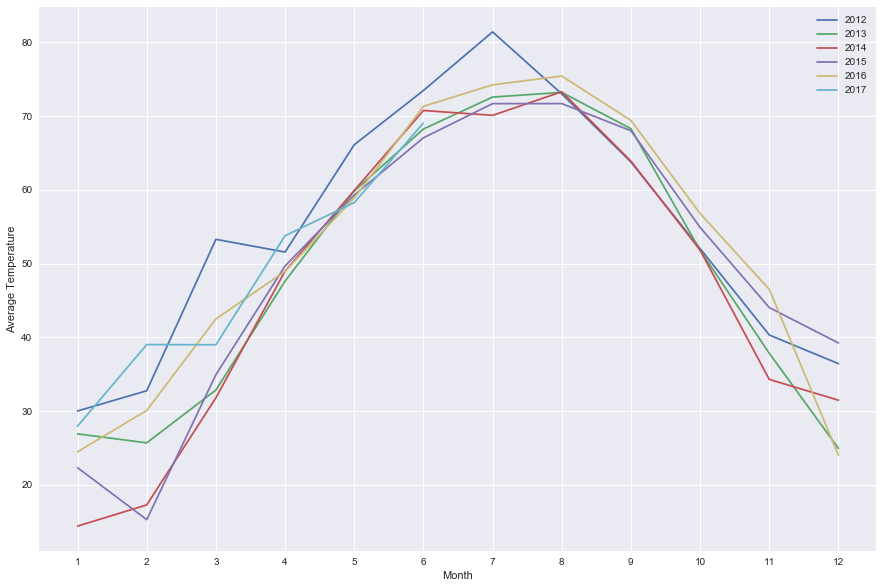

In [11]:
plt.figure()
fig, ax = plt.subplots(figsize=(15,10))
for y in C_count['Year'].unique().tolist():
    dat = C_count[C_count['Year']==y]
    dat = dat[['Year','Month','Mean_Temp']].drop_duplicates()
    dat = pd.DataFrame(dat.groupby(['Year','Month'])['Mean_Temp'].mean()) #get the mean temperature for each month
    temps = [x[0] for x in dat.values.tolist()]
    dates = dat.index.levels[1].tolist() #fixing the format of dates
    ax.plot(dates,temps,label=y)
plt.xticks(C_count[C_count['Year']==2012]['Month'].unique().tolist())
plt.xlabel('Month')
plt.ylabel("Average Temperature")
plt.legend()
plt.show()

In [12]:
#number of days with 80 degrees and higher in each year
temp[(temp['Mean_Temp']>=80) & (temp['Month']>5)].groupby('Year')['Month'].count()
#temp[(temp['Mean_Temp']>=80) & (temp['Month']>5)].groupby('Year')['Month'].count().value_counts() #uncomment this line for a break down by month

Year
2012    26
2013    13
2014     1
2015     9
2016    13
Name: Month, dtype: int64

# Most common types of crimes in the past 5 years (2012-2017)

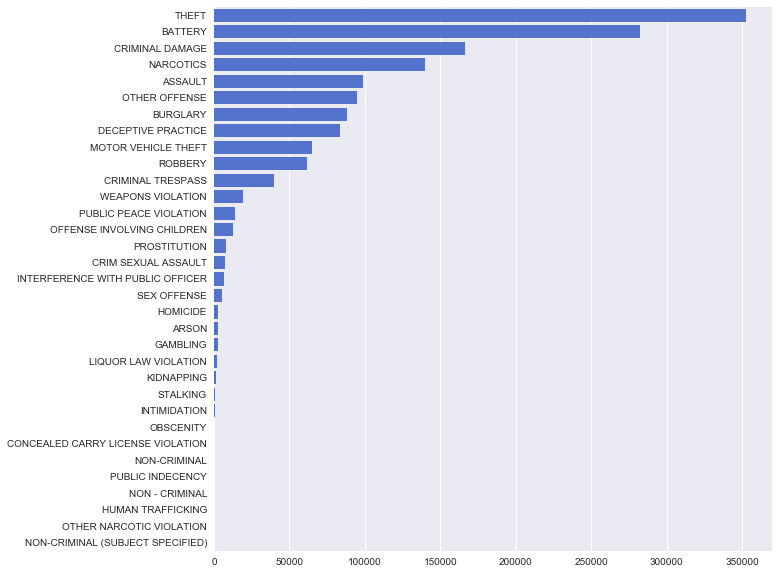

In [13]:
#in general, what are the most common types of crimes in the past 5 years
plt.figure(figsize=(10,10))
sns.barplot(y=C_count['Primary Type'].value_counts().index.tolist(),
            x=C_count['Primary Type'].value_counts().values.tolist(),data=C_count,color='royalblue',orient='h')

# Trend of crime in the past 5 years

In [14]:
#total number of crimes during the summer
crime_peak = C_count.groupby(['Year','Month'])['Primary Type'].count().reset_index() #crime peak in the summer
crime_peak[(crime_peak['Month']>5) & (crime_peak['Month']<9)].groupby('Year')['Primary Type'].sum()

Year
2012    93023
2013    84547
2014    77653
2015    71903
2016    73372
2017     5358
Name: Primary Type, dtype: int64

In [15]:
#getting the number of crimes, irrespective of crime type, in each month for each year
crime_monthly_count = C_count.groupby([C_count['Date'].dt.year,C_count['Date'].dt.month])['Primary Type'].count()
crime_monthly_count.index.names=['Year','Month']
crime_monthly_count = crime_monthly_count.reset_index()
crime_monthly_count.head(3)

,Year,Month,Primary Type
0,2012,1,26210
1,2012,2,23857
2,2012,3,28540


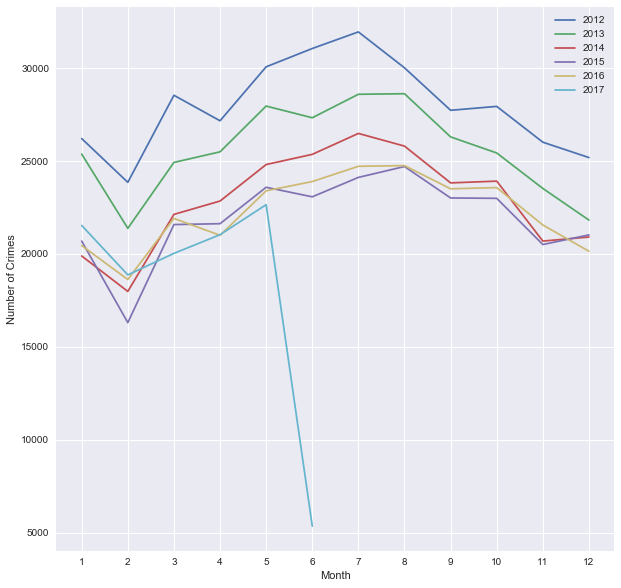

In [16]:
# the drop in 2017 is due to the incomplete data..
plt.figure()
fig, ax = plt.subplots(figsize=(10,10))
for y in crime_monthly_count['Year'].unique().tolist():
    dat = crime_monthly_count[crime_monthly_count['Year']==y]
    ax.plot(dat['Month'], dat['Primary Type'], label = y)
plt.xticks(crime_monthly_count[crime_monthly_count['Year']==2012]['Month'].unique().tolist())
plt.xlabel('Month')
plt.ylabel("Number of Crimes")
plt.legend()
plt.show()

# Rate of crime per year as a function of temperature

In [17]:
#total number of crimes per day in each month for each year
#i.e for each day, the average daily temperature was X and there were Y number of crimes.
crime_weather = C_count
crime_daily_C_Temperature  = crime_weather.groupby(['Year','Month','Day'])['Primary Type'].count()
crime_daily_C_Temperature = crime_daily_C_Temperature.reset_index()
crime_daily_C_Temperature = crime_daily_C_Temperature.merge(temp,on=['Year','Month','Day'],how='inner')
crime_daily_C_Temperature

,Year,Month,Day,Primary Type,Date,Mean_Temp
0,2012,1,1,1462,2012-01-01,36.5
1,2012,1,2,700,2012-01-02,23.5
2,2012,1,3,806,2012-01-03,20.0
3,2012,1,4,799,2012-01-04,33.0
4,2012,1,5,871,2012-01-05,36.0
5,2012,1,6,913,2012-01-06,46.5
6,2012,1,7,859,2012-01-07,36.0
7,2012,1,8,800,2012-01-08,33.5
8,2012,1,9,881,2012-01-09,35.5
9,2012,1,10,897,2012-01-10,38.5


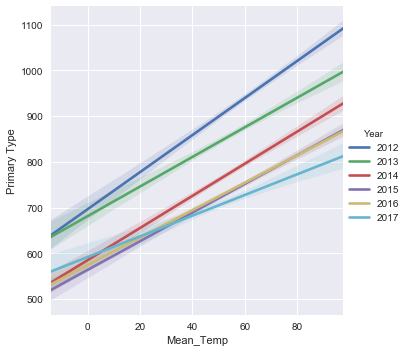

In [18]:
plt.figure(figsize=(15,15))
ax = sns.lmplot(x='Mean_Temp',y='Primary Type',hue='Year',data=crime_daily_C_Temperature,scatter=False)

# Visualizing any linear relationship between temperature and frequency of crime

In [19]:
#breaking down the total number of crimes per day by crime type.
#i.e the 1462 crimes in January 1st, 2012 is now broken down to 335 incidents of thefts, 263 incidents of battery,..etc.
crimeReg = C_count.groupby(['Year','Month','Day'])['Primary Type'].value_counts()
crimeReg = pd.DataFrame(crimeReg)
crimeReg.columns=['Count']
crimeReg = crimeReg.reset_index()
crimeReg.head(3)

,Year,Month,Day,Primary Type,Count
0,2012,1,1,THEFT,335
1,2012,1,1,BATTERY,263
2,2012,1,1,CRIMINAL DAMAGE,158


In [20]:
crimeReg_Temperature = crimeReg.merge(temp,on=['Year','Month','Day'],how='inner')
crimeReg_Temperature.head(3)
#crimeReg.to_csv('temp_reg_analysis.csv')

,Year,Month,Day,Primary Type,Count,Date,Mean_Temp
0,2012,1,1,THEFT,335,2012-01-01,36.5
1,2012,1,1,BATTERY,263,2012-01-01,36.5
2,2012,1,1,CRIMINAL DAMAGE,158,2012-01-01,36.5


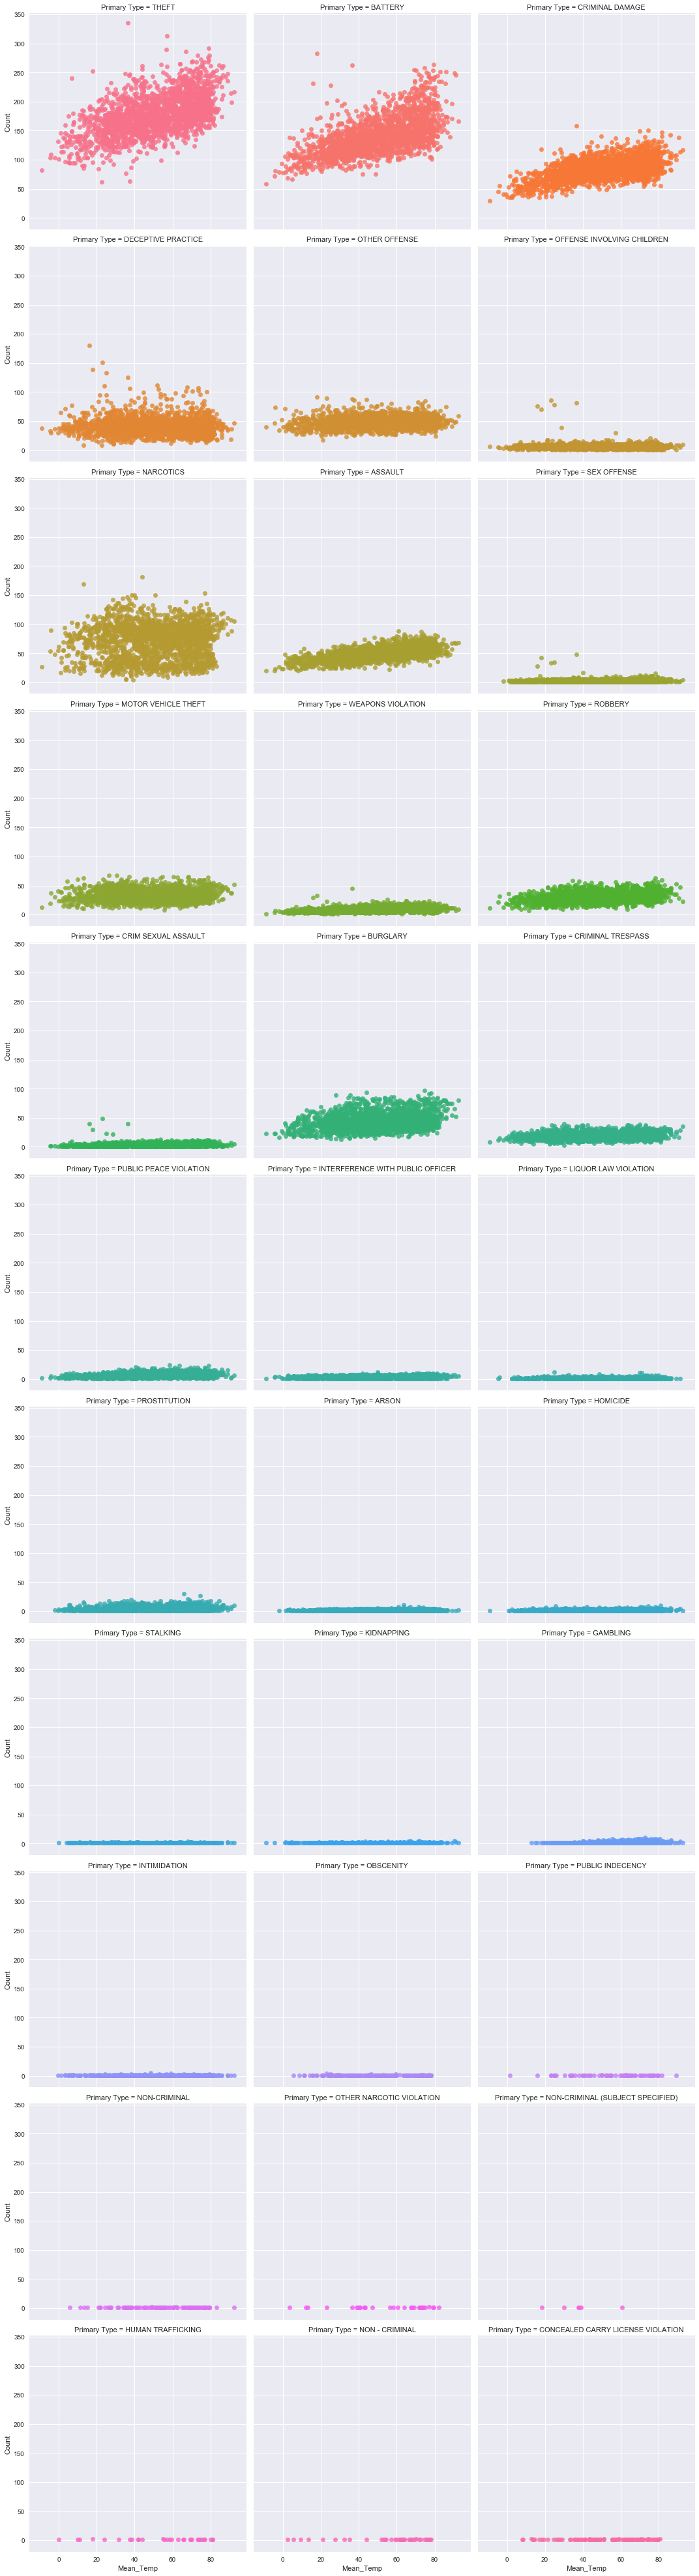

In [21]:
sns.lmplot(x='Mean_Temp',y='Count',hue='Primary Type',col='Primary Type',col_wrap=3,data=crimeReg_Temperature,scatter=True,fit_reg=False)

# Crime on week vs. weekend

In [22]:
crimeReg_Temperature.head(3)

,Year,Month,Day,Primary Type,Count,Date,Mean_Temp
0,2012,1,1,THEFT,335,2012-01-01,36.5
1,2012,1,1,BATTERY,263,2012-01-01,36.5
2,2012,1,1,CRIMINAL DAMAGE,158,2012-01-01,36.5


In [23]:
'''
Convert dates (%Y-%m-%d) to days (Sunday, Monday...etc.)
'''
def toDay(d):
    return (datetime.strptime(str(d),'%Y-%m-%d %H:%M:%S').date().strftime('%A'))
crimeReg_Temperature['Day_Words'] = crimeReg_Temperature['Date'].apply(toDay)

In [24]:
dictDay= {'Saturday':'Weekend','Sunday':'Weekend','Friday':'Weekend','Monday':'Weekday','Tuesday':'Weekday','Wednesday':'Weekday','Thursday':'Weekday','Friday':'Weekday'}
crimeReg_Temperature['Day_Words']= crimeReg_Temperature['Day_Words'].map(dictDay)

In [ ]:
crimeReg_Temperature.head(3)

,Year,Month,Day,Primary Type,Count,Date,Mean_Temp,Day_Words
0,2012,1,1,THEFT,335,2012-01-01,36.5,Weekend
1,2012,1,1,BATTERY,263,2012-01-01,36.5,Weekend
2,2012,1,1,CRIMINAL DAMAGE,158,2012-01-01,36.5,Weekend


In [ ]:
'''
Green: Weekday
Blue: Weekend

Trying to find if the relationship between crime and temperature changes between weekends and weekedays.
Only Battery and Criminal Damage tend to be high on weekends as the temperature increases.
Some of the remaining types of crimes, however, show an increase on weekdays, but not on weekends.
'''
plt.figure(figsize=(15,15))
sns.lmplot('Mean_Temp','Count',hue='Day_Words',data=crimeReg_Temperature,scatter=False,col='Primary Type',col_wrap=3)
#summary: 
#results below show that only batter tend to occure more frequently on warm days especially on weekends (which is similar to the shootings pattern).
#However, remaining patterns are mainly happening on weekdays